In [1]:
TEAM_NAME = "EXPERIMENTS"  # enter team name

In [2]:
import warnings
import numpy as np

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import numpy
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [3]:
# Set training hyperparameters (modify as needed)

shots = 500  # number of circuit executions
iterations = 50  # number of training iterations
batch_size = 30  # number of training examples used in one iteration
stepsize = 0.125  # learning rate, positive value between 0.0 and 1.0

seed = 37
Cost at step 0: 0.2402
Cost at step 1: 0.1194
Cost at step 2: 0.0616
Cost at step 3: 0.0521
Cost at step 4: 0.0406
Cost at step 5: 0.0297
Cost at step 6: 0.0377
Cost at step 7: 0.0315
Cost at step 8: 0.0266
Cost at step 9: 0.021
Cost at step 10: 0.0252
Cost at step 11: 0.0225
Cost at step 12: 0.0213
Cost at step 13: 0.0227
Cost at step 14: 0.0226
Cost at step 15: 0.0222
Cost at step 16: 0.0194
Cost at step 17: 0.022
Cost at step 18: 0.0157
Cost at step 19: 0.0112
Cost at step 20: 0.0192
Cost at step 21: 0.0151
Cost at step 22: 0.0115
Cost at step 23: 0.011
Cost at step 24: 0.0132
Cost at step 25: 0.0138
Cost at step 26: 0.0158
Cost at step 27: 0.0125
Cost at step 28: 0.0108
Cost at step 29: 0.0179
Cost at step 30: 0.0164
Cost at step 31: 0.0119
Cost at step 32: 0.0106
Cost at step 33: 0.0131
Cost at step 34: 0.0172
Cost at step 35: 0.0158
Cost at step 36: 0.0115
Cost at step 37: 0.0113
Cost at step 38: 0.0117
Cost at step 39: 0.0092
Cost at step 40: 0.0099
Cost at step 41: 0.

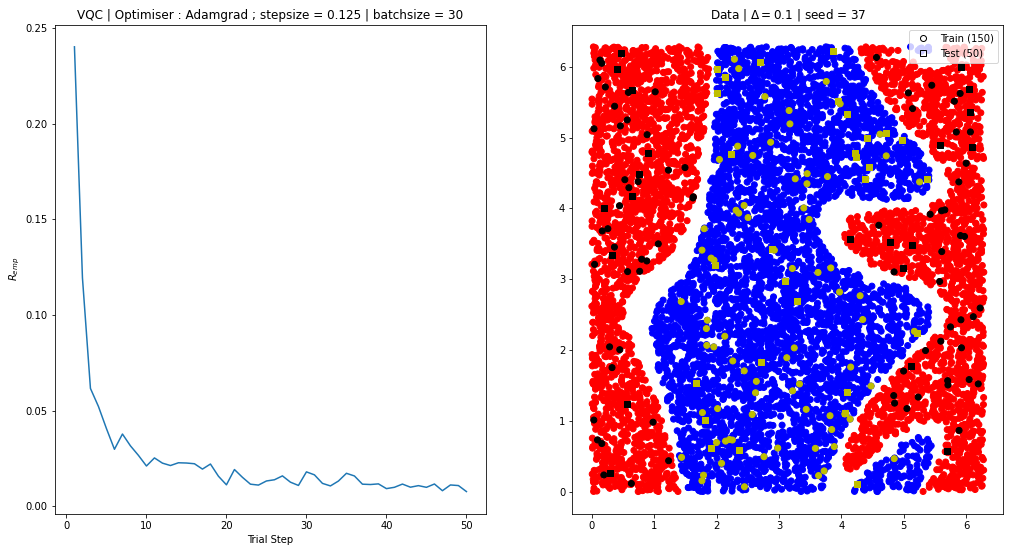

In [4]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))
%run gen_binary_rx.py


DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RX(x[0], wires=0)
        qml.RX(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(17,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()

seed = 90
Cost at step 0: 0.2112
Cost at step 1: 0.1322
Cost at step 2: 0.1195
Cost at step 3: 0.118
Cost at step 4: 0.0986
Cost at step 5: 0.0713
Cost at step 6: 0.0481
Cost at step 7: 0.039
Cost at step 8: 0.0214
Cost at step 9: 0.019
Cost at step 10: 0.0193
Cost at step 11: 0.0204
Cost at step 12: 0.0201
Cost at step 13: 0.0178
Cost at step 14: 0.0153
Cost at step 15: 0.0146
Cost at step 16: 0.0141
Cost at step 17: 0.0142
Cost at step 18: 0.0137
Cost at step 19: 0.013
Cost at step 20: 0.0151
Cost at step 21: 0.0122
Cost at step 22: 0.0137
Cost at step 23: 0.0087
Cost at step 24: 0.0121
Cost at step 25: 0.0083
Cost at step 26: 0.0096
Cost at step 27: 0.0062
Cost at step 28: 0.0063
Cost at step 29: 0.0062
Cost at step 30: 0.0052
Cost at step 31: 0.0055
Cost at step 32: 0.0068
Cost at step 33: 0.0066
Cost at step 34: 0.0094
Cost at step 35: 0.0036
Cost at step 36: 0.0046
Cost at step 37: 0.005
Cost at step 38: 0.005
Cost at step 39: 0.005
Cost at step 40: 0.0064
Cost at step 41: 0.0053

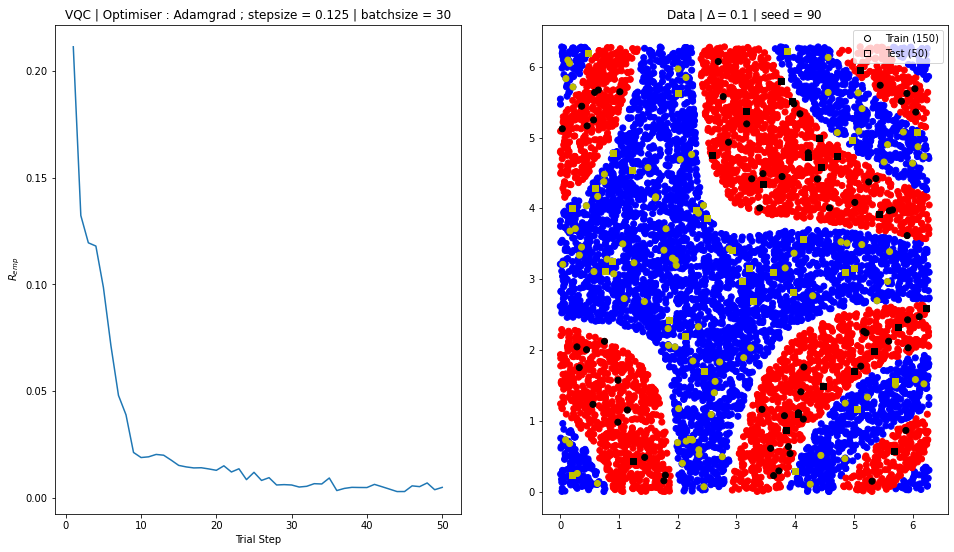

In [5]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))
%run gen_binary_rx.py


DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RX(x[0], wires=0)
        qml.RX(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(16,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()

seed = 22
Cost at step 0: 0.5202
Cost at step 1: 0.2257
Cost at step 2: 0.1821
Cost at step 3: 0.2057
Cost at step 4: 0.1944
Cost at step 5: 0.1796
Cost at step 6: 0.1482
Cost at step 7: 0.1314
Cost at step 8: 0.111
Cost at step 9: 0.1049
Cost at step 10: 0.103
Cost at step 11: 0.1037
Cost at step 12: 0.1034
Cost at step 13: 0.1026
Cost at step 14: 0.0858
Cost at step 15: 0.0976
Cost at step 16: 0.0839
Cost at step 17: 0.0905
Cost at step 18: 0.0833
Cost at step 19: 0.0798
Cost at step 20: 0.0741
Cost at step 21: 0.0851
Cost at step 22: 0.0852
Cost at step 23: 0.0893
Cost at step 24: 0.0806
Cost at step 25: 0.0732
Cost at step 26: 0.0786
Cost at step 27: 0.0816
Cost at step 28: 0.0714
Cost at step 29: 0.0735
Cost at step 30: 0.0674
Cost at step 31: 0.0732
Cost at step 32: 0.0681
Cost at step 33: 0.0612
Cost at step 34: 0.067
Cost at step 35: 0.0677
Cost at step 36: 0.0692
Cost at step 37: 0.0691
Cost at step 38: 0.066
Cost at step 39: 0.0715
Cost at step 40: 0.0654
Cost at step 41: 0.0

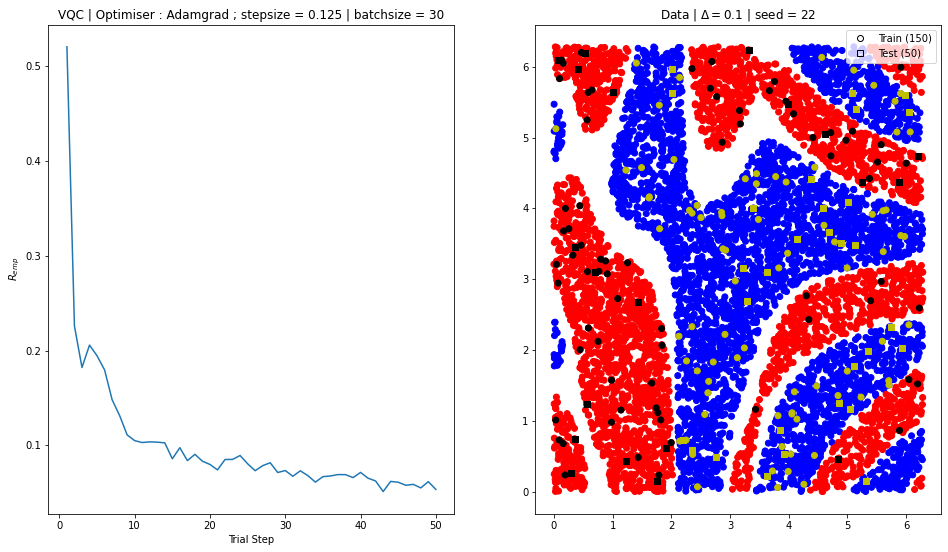

In [6]:
seed = numpy.random.randint(low=0,high= 100)
print("seed = "+ str(seed))
%run gen_binary_rx.py


DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_samples = 200  # number of train/test samples
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data)

def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
depth = 2  # number of layers in ansatz
pset = powerset(range(n_wires), S_size)

def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

def feature_map(x):
    """Short depth feature map with entanglement

    Args:
        x : shape (3,) tensor containing one encoded data vector
    """
    for _ in range(2):
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        qml.RX(x[0], wires=0)
        qml.RX(x[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RX(x[2], wires=1)
        qml.CNOT(wires=[0, 1])

def ansatz(params):
    """VQC ansatz using single-qubits unitaries and entangling gates

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
    """
    for j in range(n_wires):
         qml.Rot(params[0, j, 0], params[0, j, 1], params[0, j, 2], wires=j)
    
    for i in range(1,depth+1):
         for s in pset:
            qml.CZ(wires=s)
            for j in range(n_wires):
                qml.Rot(params[i, j, 0], params[i, j, 1], params[i, j, 2], wires=j)

def circuit(params, x):
    """Havlicek et al. variational quantum circuit

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        x : shape (2,) tensor containing one input data vector

    Returns:
        shape(2 * 'n_wires',) tensor containing Z basis measurement probability on each qubit
    """

    feature_map(encode_data(x))  # prepare initial feature map state
    ansatz(params)  # apply discriminator circuit

    return qml.probs(wires=range(n_wires))


dev_local = qml.device("default.qubit", wires=n_wires, shots=shots)

qnode_local = qml.QNode(circuit, dev_local)

np.random.seed(seed)
params = (
    2 * np.pi * np.random.randn(depth + 1, n_wires, 3, requires_grad=True)
)  # random initial circuit parameters

def err_prob(params, x, y, R, bias=0):
    """Error probability of assigning a wrong label

    Args:
        x : shape (2,) tensor containing one input data vector
        y : shape (1,) tensor containing associated label
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        R : int number of circuit evaluations (shots)
        bias : optional bias parameter in [-1,+1]

    Returns:
        probability that the VQC computed label m(x) = y' is assigned incorrectly
    """

    bprobs = qnode_local(params, x)  # probabilities for each basis state
    cprobs = (
        bprobs[0] + bprobs[3],
        bprobs[1] + bprobs[2],
    )  # probabilities for each eigenstate of parity Z_1 Z_2
    prob_correct = cprobs[int(0.5 - 0.5 * y)]  # probability of choosing correct label

    # Intermediate evaluation of equation from supplement using derived p_y(x) i.e. prob_correct
    val = (np.sqrt(R) * (0.5 - prob_correct - 0.5 * y * bias)) / (
        np.sqrt(2 * (1 - prob_correct) * prob_correct)
    )

    return 1 / (
        1 + np.exp(-val)
    )  # binomial CDF for R >> 1 approximated using sigmoid function

def cost(params, Xs, Ys, R):
    """Cost function for circuit optimization

    Args:
        params : shape (`depth` + 1, `n_wires`, 3) tensor containing trainable parameters
        Xs : shape (n,2) tensor containing input data vectors
        Ys : shape (n,) tensor containing associated labels
        R : int number of circuit evaluations (shots)

    Returns:
        the empirical risk i.e. the error probability averaged over all data points

    """

    ep_sum = 0  # initialize error probabilities sum
    for i in range(
        Xs.shape[0]
    ):  # compute sum of error probabilities over all data points
        ep_sum += err_prob(params, Xs[i], Ys[i], R)

    return ep_sum / Xs.shape[0]  # return average over all data points

# Gradient-based training
costs = []
times = []

opt = qml.AdagradOptimizer(stepsize)

for i in range(iterations):

    # Generate the batch
    batch_index = np.random.randint(0, X_train.shape[0], (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    t0 = time.time()

    # Update parameters by a single step.
    params = opt.step(lambda var: cost(var, X_batch, Y_batch, shots), params)

    t1 = time.time()

    # Compute cost
    cost_current = cost(params, X_train, Y_train, shots)
    

    costs.append(cost_current)
    times.append(t1 - t0)
    print(f"Cost at step {i}: {round(float(costs[-1]), 4)}") ##checkflag
    # print(f"Time at step {i}: {round(float(times[-1]), 4)}") ##checkflag

print(f"Initial cost: {round(float(costs[0]), 4)}")
print(f"Cost at step {iterations}: {round(float(costs[-1]), 4)}")
print(f"Avg time per step: {round(sum(times)/len(times), 4)} sec")

# Output folder
# time_str = time.strftime("%Y%m%d-%H%M%S")
VQC_OUT = f"vqc/{str(seed)}"
os.makedirs(VQC_OUT, exist_ok=True)

params_csv = f"{VQC_OUT}/{TEAM_NAME}_params.csv"
costs_csv = f"{VQC_OUT}/{TEAM_NAME}_costs.csv"

np.savetxt(params_csv, params.reshape(n_wires * (depth + 1), 3))
print(f"\nParameters saved to {params_csv}")

np.savetxt(
    costs_csv,
    np.vstack((range(iterations), costs[:iterations])).T,
    delimiter=", ",
)
print(f"Costs saved to {costs_csv}")

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

fig, ax = plt.subplots(1,2, figsize=(16,9))

ax[0].set_title("VQC | Optimiser : Adamgrad ; stepsize = " + str(stepsize) +" | batchsize = "+ str(batch_size))
ax[0].set_xlabel("Trial Step")
ax[0].set_ylabel("$R_{emp}$")
ax[0].plot(range(1, iterations + 1), costs)

ax[1].set_title(f"Data | $\Delta = {delta}$" + " | seed = " + str(seed))
ax[1].scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
ax[1].scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
ax[1].scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
ax[1].legend(handles=[label_circle, label_square], loc="upper right")


plt.savefig(DATA_PATH + "exp_rz | seed = "+str(seed) )

plt.show()